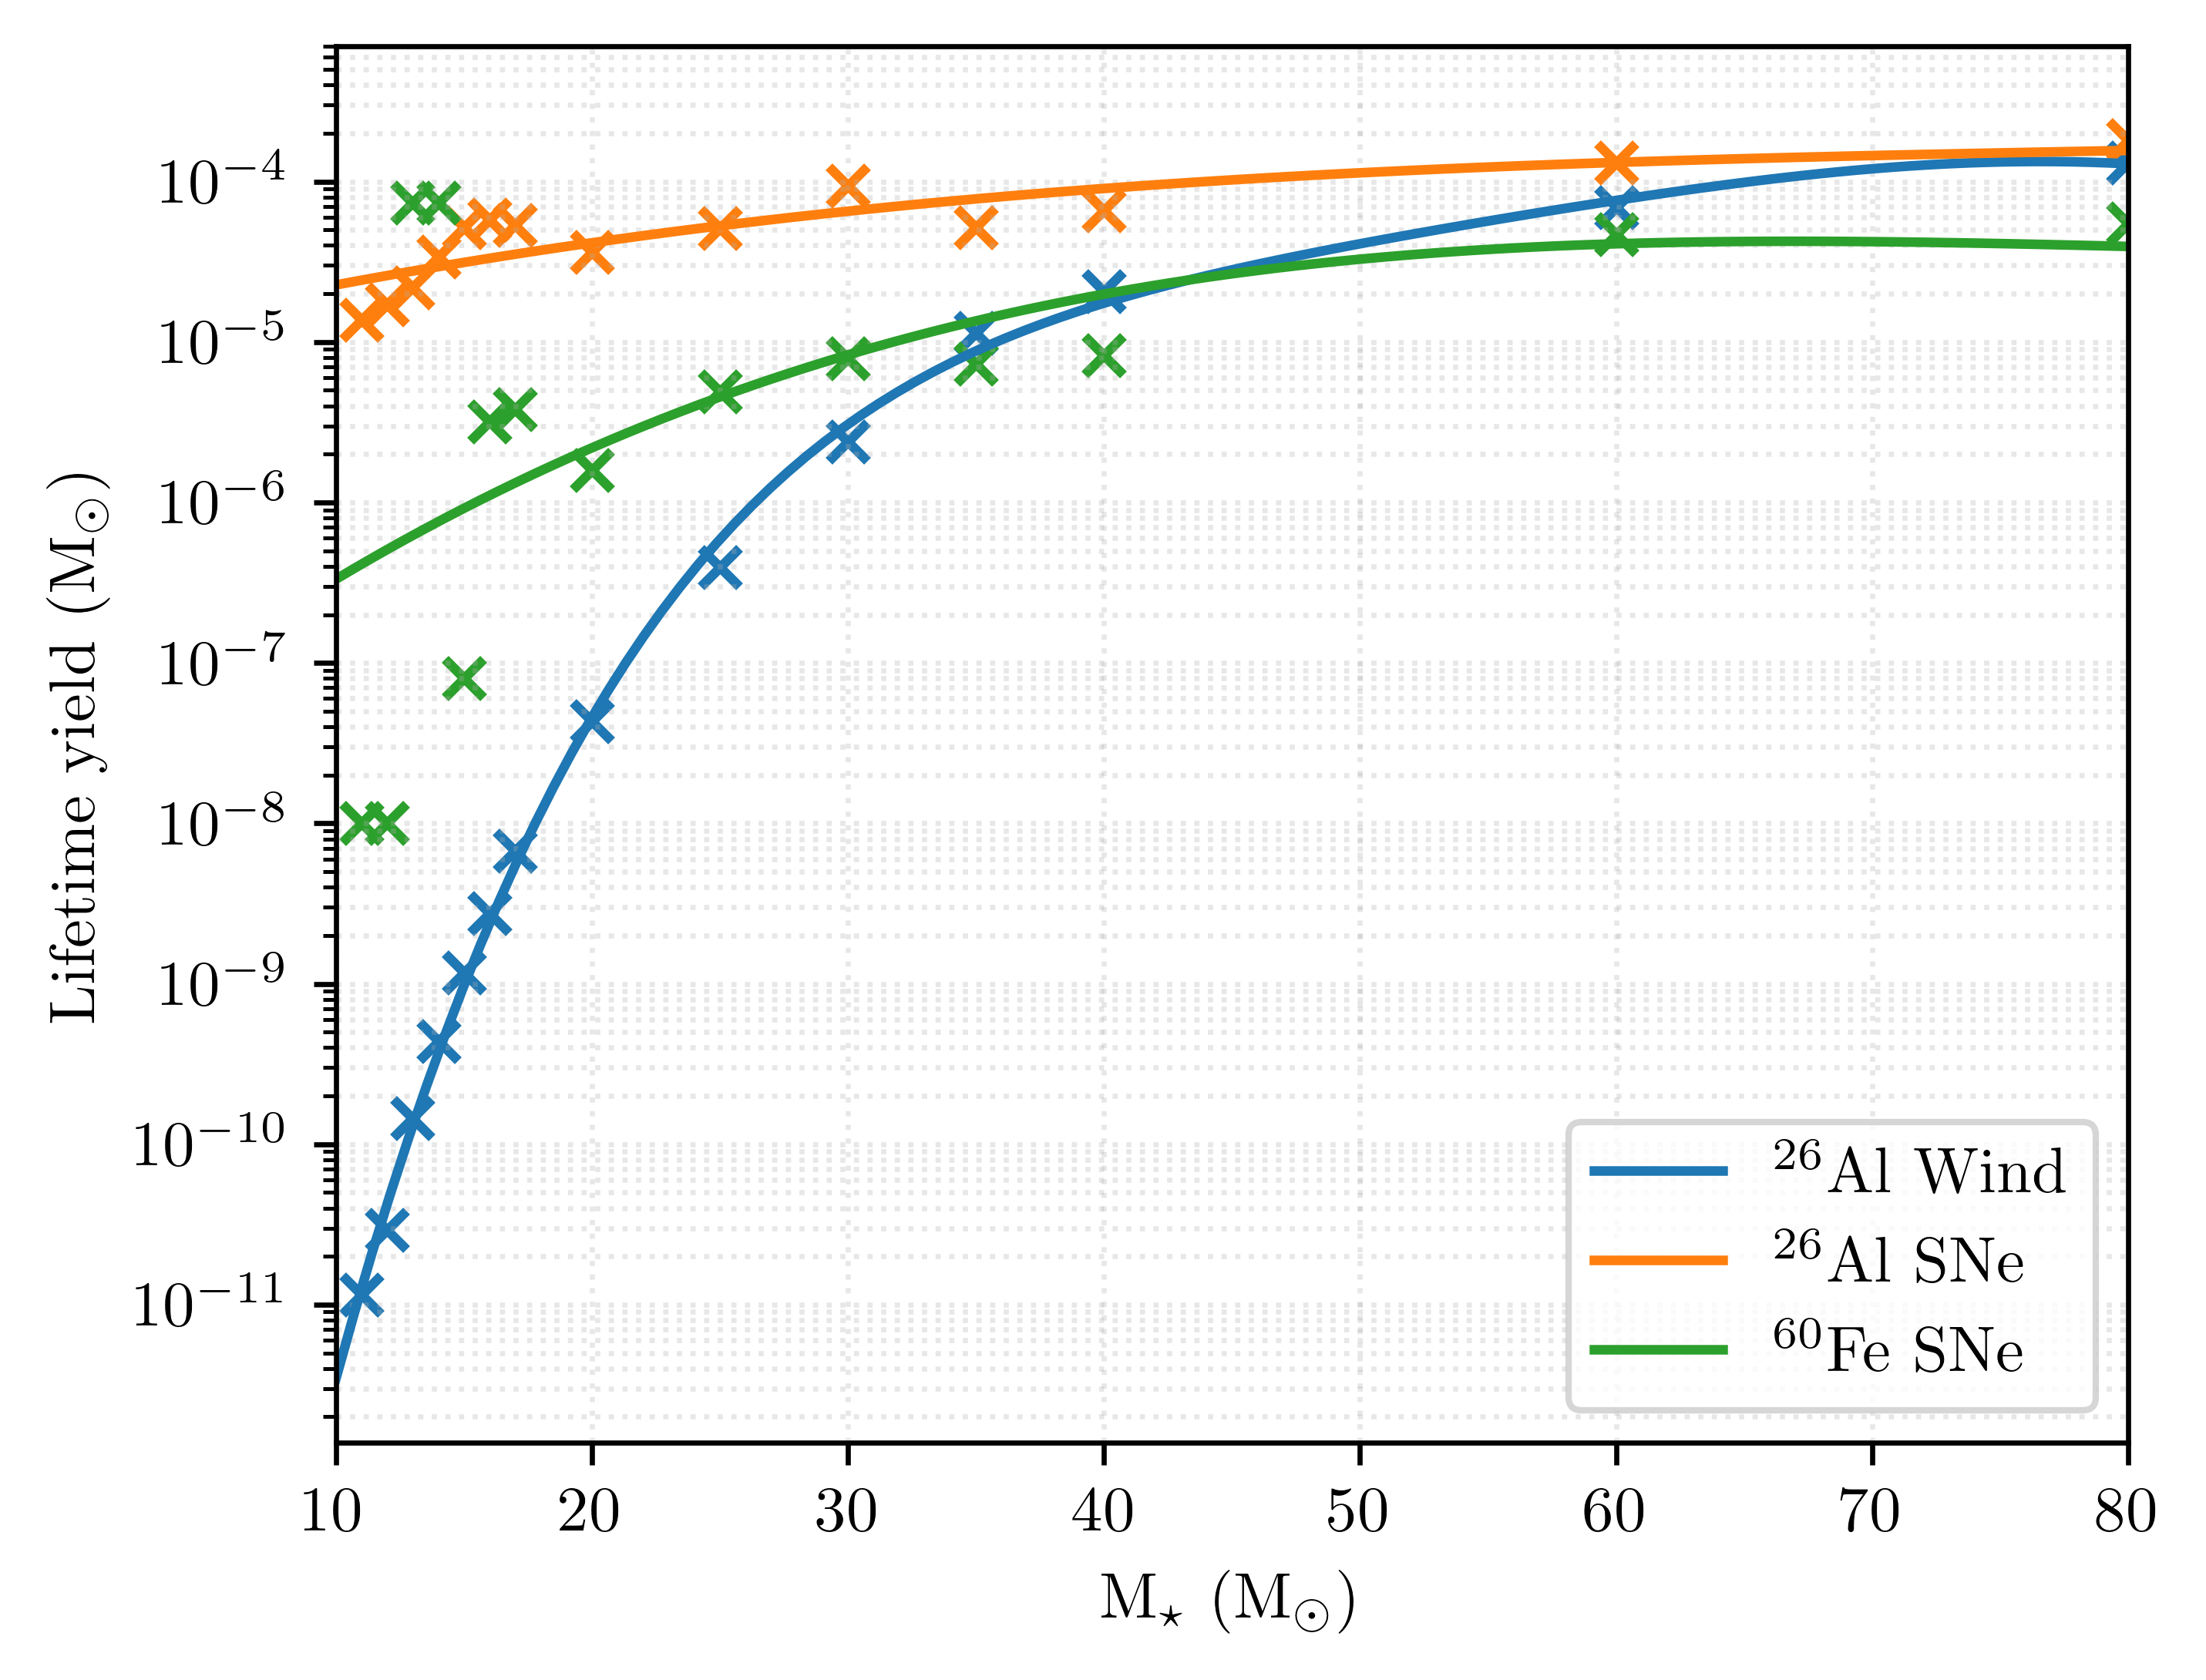

In [1]:

from numpy import genfromtxt,polyfit,poly1d,log10,linspace
import matplotlib.pyplot as plt

data = genfromtxt("table-3.dat",delimiter=",")

mass = data[:,0]
al_wind = data[:,2]
al_sne  = data[:,4]
fe_sne  = data[:,10]

al_wind_fit = polyfit(mass,log10(al_wind),5)
al_wind_1d  = poly1d(al_wind_fit)

al_sne_fit = polyfit(mass,log10(al_sne),3)
al_sne_1d  = poly1d(al_sne_fit)

fe_sne_fit = polyfit(mass,log10(fe_sne),3)
fe_sne_1d  = poly1d(fe_sne_fit)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
  })
plt.figure(figsize=(5,4),dpi=600)

massr = linspace(10,80,100)
plt.grid(True, which="both", ls="dotted",alpha=0.3)

plt.scatter(mass,al_wind,marker="x")
plt.semilogy(massr,10**al_wind_1d(massr),label="$^{26}$Al Wind")
plt.scatter(mass,al_sne,marker="x")
plt.semilogy(massr,10**al_sne_1d(massr),label="$^{26}$Al SNe")
plt.scatter(mass,fe_sne,marker="x")
plt.semilogy(massr,10**fe_sne_1d(massr),label="$^{60}$Fe SNe")

plt.xlim((10,80))
plt.ylabel("Lifetime yield (M$_\odot$)")
plt.xlabel("M$_\star$ (M$_\odot$)")

plt.legend(fancybox=True)
plt.savefig("limongi.pdf",bbox_inches="tight")



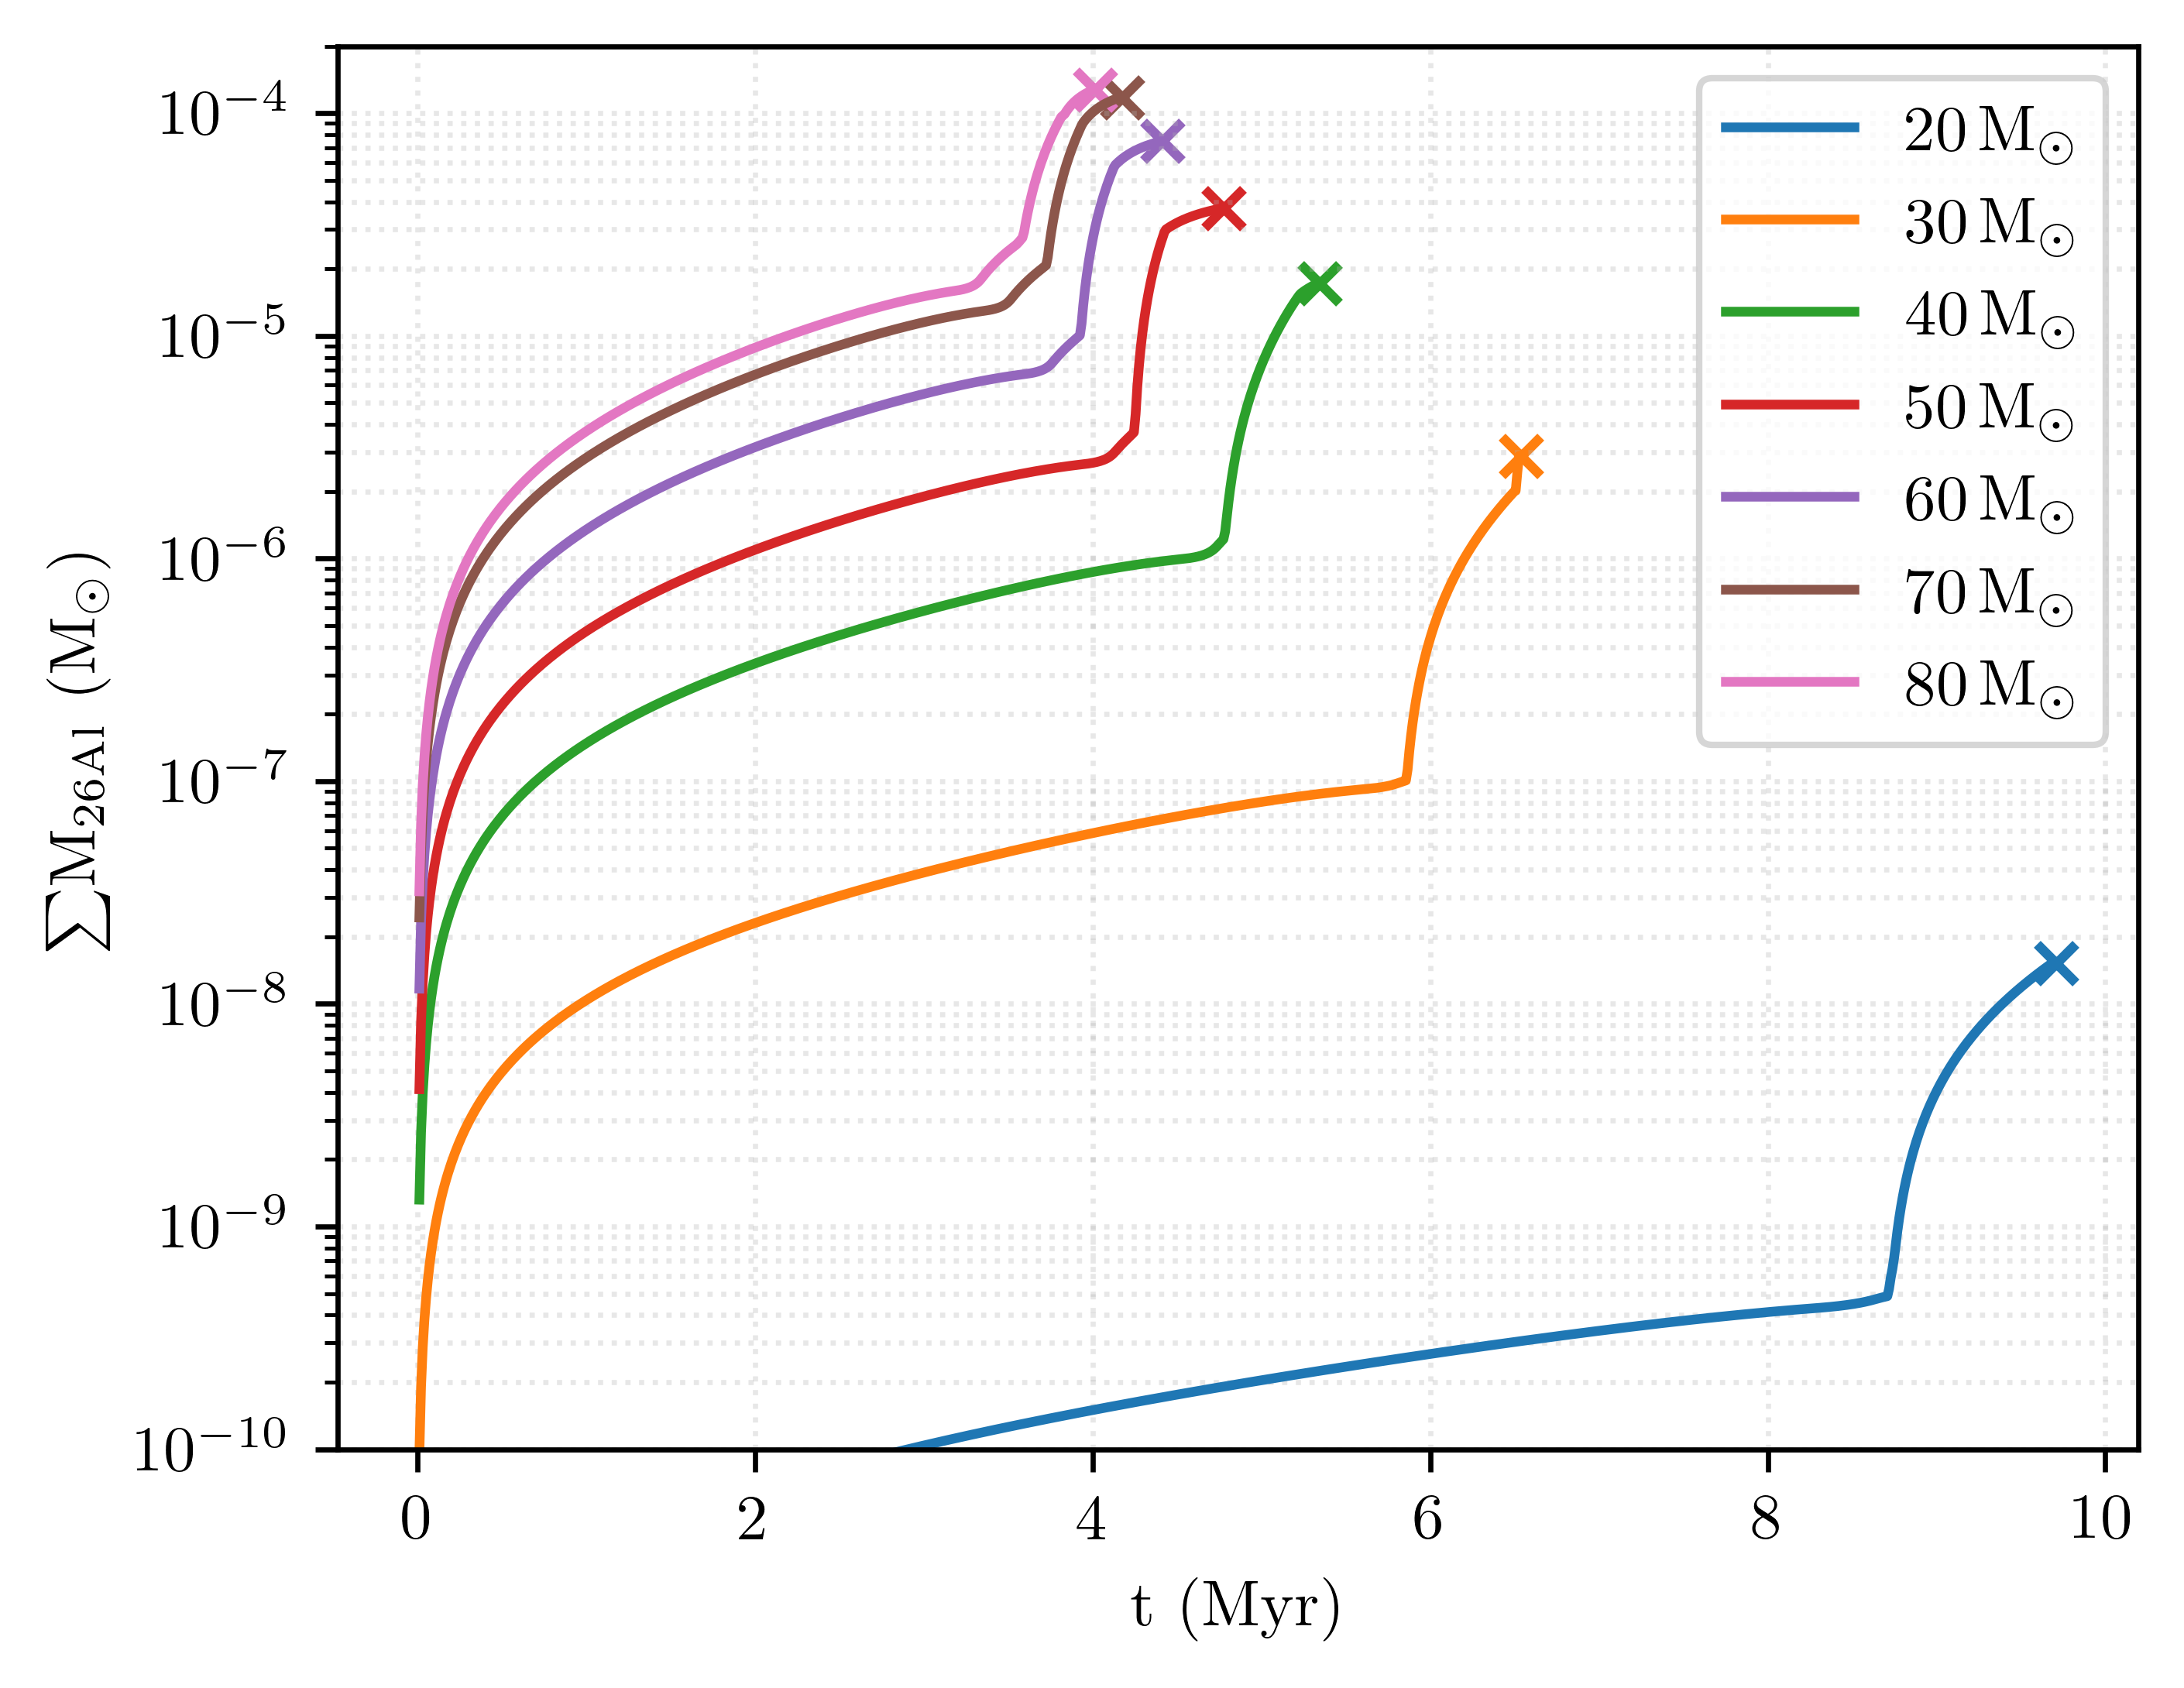

In [2]:
import sys
sys.path.append("../")
from al26_nbody import Al26WindRatio
import numpy as np
import matplotlib.pyplot as plt

from amuse.lab import SeBa
from amuse.datamodel import Particles
from amuse.units import units

from scipy import integrate

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
  })
plt.figure(figsize=(5,4),dpi=600)
plt.grid(True, which="both", ls="dotted",alpha=0.3)

massr = [20,30,40,50,60,70,80] | units.MSun
nmass = len(massr)

stars = Particles(nmass)
stars.mass = massr

stellar = SeBa()
stellar.particles.add_particles(stars)

tr = np.linspace(0,10.,1000) | units.Myr
mr = []
for t in tr:
  stellar.evolve_model(t)
  mr.append(abs(stellar.particles.wind_mass_loss_rate.value_in(units.MSun/units.yr)))
mr = np.asarray(mr)

for i in range(nmass):
  wr = Al26WindRatio(massr[i])
  x = tr.value_in(units.yr)
  y = mr[:,i] * wr
  y_int = integrate.cumtrapz(y, x, initial=0)

  x_plt = []
  y_plt = []
  for j in range(1,len(y_int)):
    x_plt.append(x[j]/1e6)
    y_plt.append(y_int[j])
    if y_int[j-1] == y_int[j]:
      break
  label = r"{}$\,$M$_\odot$".format(massr[i].value_in(units.MSun))
  plt.semilogy(x_plt,y_plt,label=label)
  plt.scatter(x_plt[-1],y_plt[-1],marker="x")

plt.legend()
plt.xlabel("t (Myr)")
plt.ylabel("$\sum$M$_\mathrm{26Al}$ (M$_\odot$)")
plt.ylim((1e-10,2e-4))
plt.savefig("cumulative_yield.pdf",bbox_inches="tight")
plt.show()

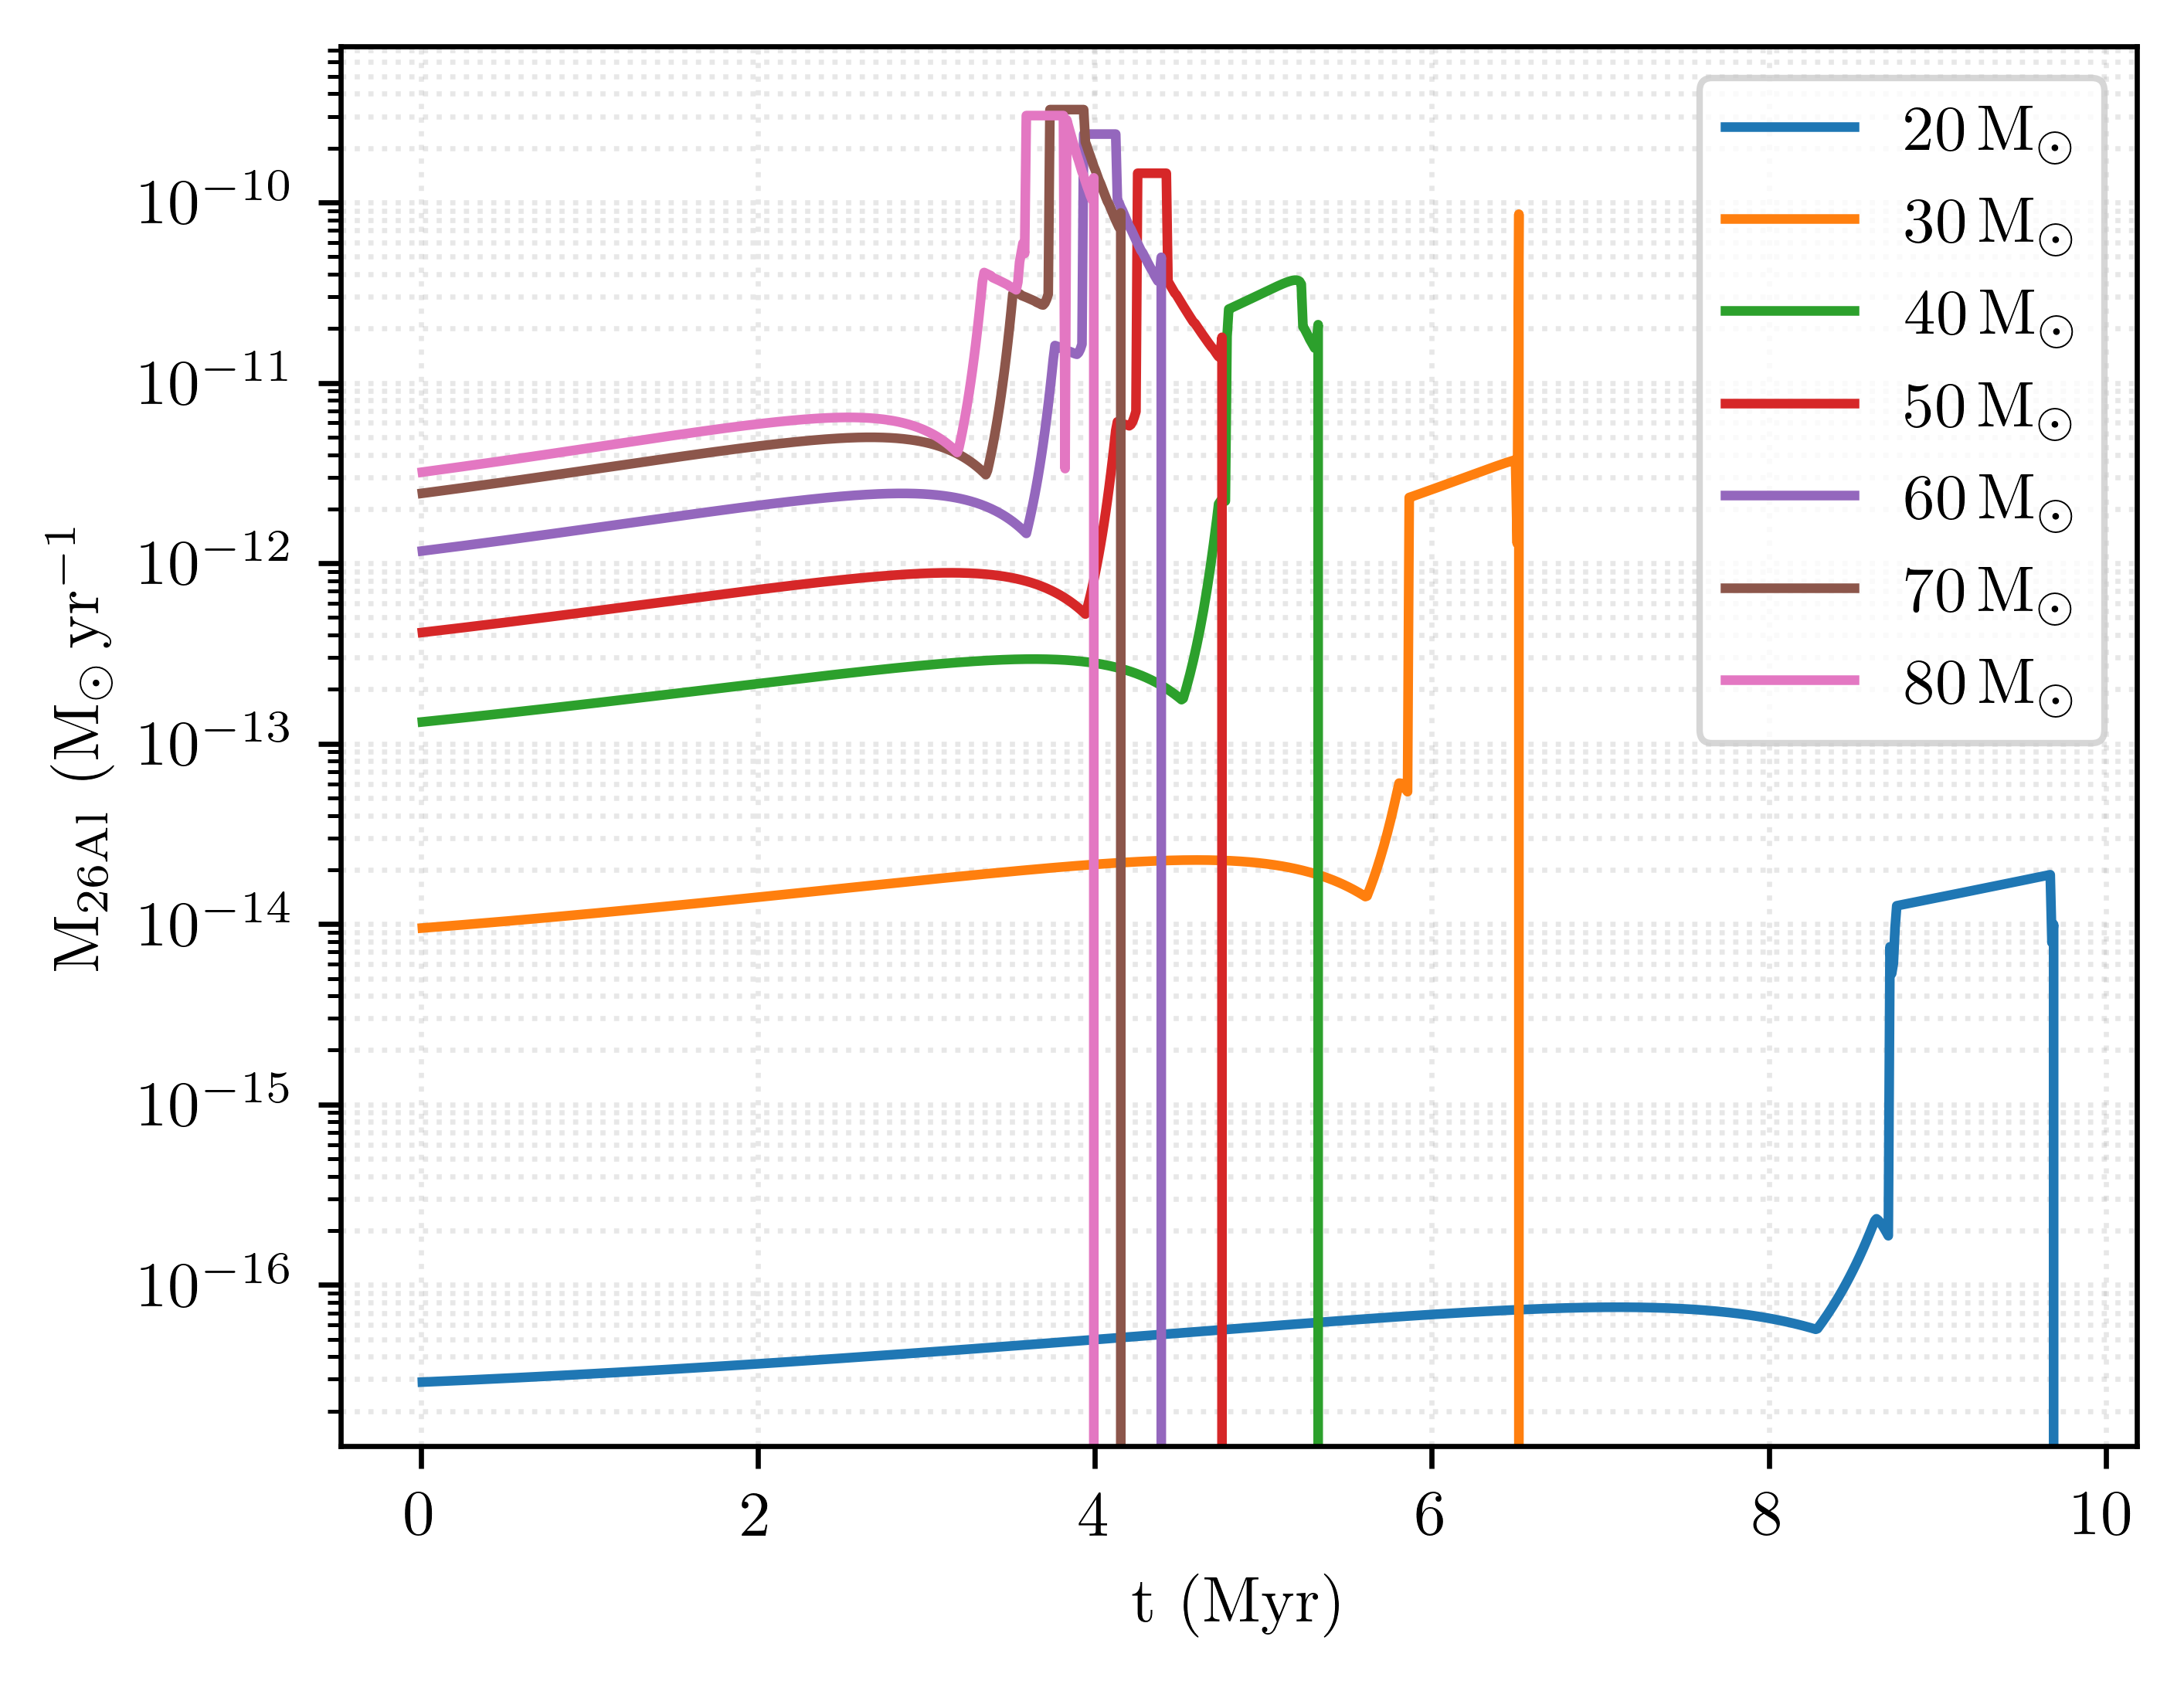

In [3]:
plt.figure(figsize=(5,4),dpi=600)
plt.grid(True, which="both", ls="dotted",alpha=0.3)

for i in range(nmass):
  wr = Al26WindRatio(massr[i])
  x = tr.value_in(units.Myr)
  y = mr[:,i] * wr 
  
  x_plt = []
  y_plt = []
  for j in range(1,len(y_int)):
    x_plt.append(x[j])
    y_plt.append(y[j])
    if y[j] == 0.0:
      break
  label = r"{}$\,$M$_\odot$".format(massr[i].value_in(units.MSun))
  plt.semilogy(x_plt,y_plt,label=label)
  plt.scatter(x_plt[-1],y_plt[-1],marker="x")

plt.legend()
plt.xlabel("t (Myr)")
plt.ylabel("M$_\mathrm{26Al}$ (M$_\odot\,$yr$^{-1}$)")
plt.savefig("yield.pdf",bbox_inches="tight")